**Modelos generativos: Variational autoencoder com encoder/decoder Conv2D**

In [25]:
import sys, os 
os.environ['KERAS_BACKEND'] = "tensorflow"


import keras
from keras import backend as K
#from keras import layers
from keras.layers import Input, Dense, Flatten, Conv2D, Reshape, Conv2DTranspose, Lambda
#from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras.layers import Input, Dense
from keras.utils import np_utils

from keras.callbacks import ModelCheckpoint
import sys, os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from livelossplot import PlotLossesKeras

%matplotlib inline

In [26]:
#para melhor gestão memória GPU por parte do tensorflow
import tensorflow as tf     

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica


(60000, 28, 28)


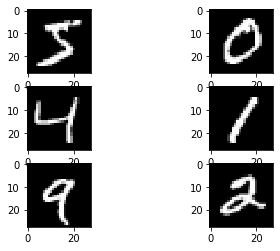

shape[0]:  60000
shape antes:  (60000, 28, 28)
shape depois:  (60000, 28, 28, 1)


In [27]:
def load_mnist_dataset(path='mnist.npz'):
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist(X_train):
    #(X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap='gray')
    plt.subplot(322)
    plt.imshow(X_train[1], cmap='gray')
    plt.subplot(323)
    plt.imshow(X_train[2], cmap='gray')
    plt.subplot(324)
    plt.imshow(X_train[3], cmap='gray')
    plt.subplot(325)
    plt.imshow(X_train[4], cmap='gray')
    plt.subplot(326)
    plt.imshow(X_train[5], cmap='gray')
    plt.show()
    
def data_preparation_2D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    visualize_mnist(X_train)
    # transformar para o formato [instancias][largura * altura]
    print("shape[0]: ",X_train.shape[0])
    print("shape antes: ",X_train.shape)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    print("shape depois: ",X_train.shape)
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    #y_train = np_utils.to_categorical(y_train)
    #y_test = np_utils.to_categorical(y_test)
    num_classes = 10 # y_test.shape[1]
    return X_train, X_test, y_train, y_test, num_classes
  
    
X_train, X_test, y_train, y_test, num_classes = data_preparation_2D()
   

In [28]:
def create_encoder():
    input_image= Input(shape=(28, 28, 1)) #imagens do MNIST
    encoded1 = Conv2D(32, 3, padding='same', activation='relu')(input_image)
    encoded2 = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(encoded1)#com stride (2,2) vais diminuir a dimensão da imagem
    encoded3 = Conv2D(64, 3, padding='same', activation='relu')(encoded2)
    encoded4 = Conv2D(64, 3, padding='same', activation='relu')(encoded3)
    encoded5 = Flatten()(encoded4)
    encoded6 = Dense(32, activation='relu')(encoded5)
    t_mean = Dense(2)(encoded6) #o 2 refere-se à dimensão do latent space
    t_log_var = Dense(2)(encoded6)
    #ver documentação do keras:
    #Output of the created model are the sufficient statistics
    #of the variational distriution q(t|x;phi), mean and log variance.
    encoder = Model(inputs=input_image, outputs=[t_mean, t_log_var], name='encoder')
    return encoder

def create_decoder():
    decoder_input = Input(shape=(2,)) #o 2 refere-se à dimensão do latent space (sampling)
    decoded1 = Dense(12544, activation='relu')(decoder_input) #12544 = 14*14*64
    decoded2 = Reshape((14, 14, 64))(decoded1)
    decoded3 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(decoded2)
    decoded4 = Conv2D(1, 3, padding='same', activation='sigmoid')(decoded3)
    #Outputs são imagens com shape (28, 28, 1) onde o valor de cada pixel corresponde à prob. de ser branco
    decoder = Model(inputs=decoder_input, outputs=decoded4, name='decoder')
    return decoder

encoder = create_encoder()
decoder = create_decoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### DECODER #################")
decoder.summary()



############### ENCODER #################
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 32)   320         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_17[0][0]                  
_________________________________________________

In [29]:
# em vez de codificar uma entrada como um único ponto, vamos codificar como uma distribuição no espaço latente

#código baseado no exemplo da documentação do keras
def sample(args):
    '''
    Draws samples from a standard normal and scales the samples with
    standard deviation of the variational distribution and shifts them
    by the mean.
    Args: sufficient statistics of the variational distribution.
    Returns: Samples from the variational distribution.
    '''
    t_mean, t_log_var = args
    t_sigma = K.sqrt(K.exp(t_log_var))
    epsilon = K.random_normal(shape=K.shape(t_mean), mean=0., stddev=1.)
    return t_mean + t_sigma * epsilon

#Lambda layers in Keras help you to implement layers or functionality that is not prebuilt 
#and which do not require trainable weights.
def create_sampler(): #Creates a sampling layer.
    return Lambda(sample, name='sampler') #Lambda refer-se ao layer.Lambda

sampler = create_sampler()

def create_vae():
    input_image = Input(shape=(28, 28, 1))
    t_mean, t_log_var = encoder(input_image)
    t = sampler([t_mean, t_log_var]) #novo layer para fazer o sampling
    t_decoded = decoder(t)
    vae = Model(input_image, t_decoded, name='vae')
    return vae, t_mean, t_log_var

vae,t_mean, t_log_var = create_vae()
print("\n############### VARIATIONAL AUTOENCODER #################")
vae.summary()


############### VARIATIONAL AUTOENCODER #################
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 494244      input_12[0][0]                   
__________________________________________________________________________________________________
sampler (Lambda)                (None, 2)            0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________________________________________________________________________
decoder (Model)                 (None

In [30]:
#ver documentação do keras (variational autoencoders)
def neg_variational_lower_bound(input_image, t_decoded):
    '''
    Negative variational lower bound used as loss function
    for training the variational auto-encoder.
    Args:  input_image: input images
           t_decoded: reconstructed images
    '''
    # Reconstruction loss
    rc_loss = K.sum(K.binary_crossentropy(K.batch_flatten(input_image), K.batch_flatten(t_decoded)), axis=-1)
    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=-1)
    # Average over mini-batch
    return K.mean(rc_loss + kl_loss)

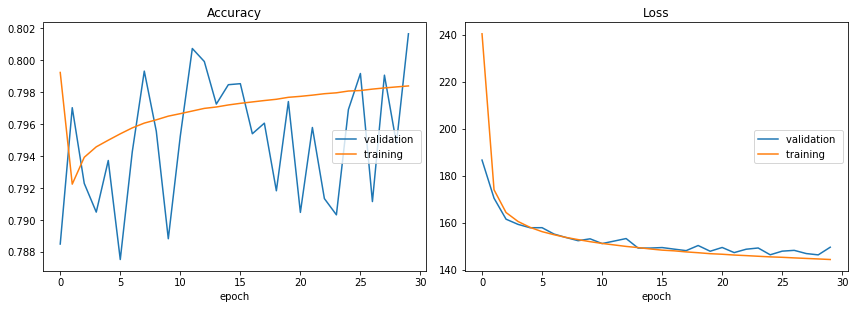

Accuracy
	validation       	 (min:    0.788, max:    0.802, cur:    0.802)
	training         	 (min:    0.792, max:    0.799, cur:    0.798)
Loss
	validation       	 (min:  146.013, max:  186.617, cur:  149.545)
	training         	 (min:  144.281, max: 147621452.885, cur:  144.313)

Epoch 00030: val_loss did not improve from 146.28663


In [31]:
def compiletrain(vae, X_train, X_test):
    metrics = ['accuracy']
    vae.compile(optimizer='rmsprop', loss=neg_variational_lower_bound, metrics=metrics)
    checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_loss', verbose=1, save_best_only=True)
    history = vae.fit(x=X_train, y=X_train, 
                      epochs=30, #25, 
                      shuffle=True, 
                      batch_size=128, 
                      validation_data=(X_test, X_test), 
                      verbose=0,
                      callbacks=[PlotLossesKeras(),checkpointer])
    vae.load_weights('best_weights.hdf5')
    vae.save('model_vae_v1.h5') #isto não funciona devido à layer de sampling
    return vae, history

vae = compiletrain(vae, X_train, X_test)